# Systems Biology Informed Neural Network

We aim to reimplement the SBINN from the article _Systems Biology: Identifiability analysis and parameter
identification via systems-biology informed neural networks_, M. Daneker et al., 2023, [link](https://arxiv.org/pdf/2202.01723.pdf). This is a `jinns` adaptation of the [code](https://github.com/lu-group/sbinn) acoompanying the article. Results are discussed [here](https://github.com/lu-group/sbinn/issues/4).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

2024-09-17 11:52:08.702980: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

# Load the observed data

In [5]:
gluc_data = np.hsplit(np.loadtxt("sbinn_data/glucose.dat"), [1])
data_t = gluc_data[0]
data_y = gluc_data[1]

# Creation of a large SystemLoss in `jinns`

## 1. Create the datagenerators objects

In [6]:
n = int(2**12)
batch_size = 256
method = "uniform"
tmin = 0
tmax = 1800

Tmax = 1
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    subkey, n, tmin, tmax, batch_size, method=method
)

n = 1800
key, subkey = random.split(key)
idx = jnp.append(
    jax.random.choice(subkey, jnp.arange(1, n - 1), shape=(n // 5,), replace=False),
    jnp.array([0, n - 1]),
)


key, subkey = random.split(key)
obs_batch_size = 256  # must be equal to time_batch_size !
obs_data = jinns.data.DataGeneratorObservationsMultiPINNs(
    obs_batch_size,
    observed_pinn_in_dict={
        "G": data_t[idx].squeeze() / Tmax,
        "Ip": None,
        "Ii": None,
        "h1": None,
        "h2": None,
        "h3": None,
    },
    observed_values_dict={
        "G": data_y[idx, 2],
        "Ip": None,
        "Ii": None,
        "h1": None,
        "h2": None,
        "h3": None,
    },
    key=subkey,
)

## 2 Create the neural networks

The following cells create 6 neural networks for the 6 outputs we are trying 
to predict.

**Important:** both the input (feature) `t` and the ouput of the network change in this 
example. To do this, we use the `input_transform` and `output_transform`
functionnalities of the PINN creation. Below we define the transformation as 
described in the original work we are trying to reproduce.

In [7]:
eqx_list = [
    [eqx.nn.Linear, 6, 40],
    [jax.nn.tanh],
    [eqx.nn.Linear, 40, 40],
    [jax.nn.tanh],
    [eqx.nn.Linear, 40, 40],
    [jax.nn.tanh],
    [eqx.nn.Linear, 40, 40],
    [jax.nn.tanh],
    [eqx.nn.Linear, 40, 40],
    [jax.nn.tanh],
    [eqx.nn.Linear, 40, 1],
]


def feature_transform(t, params):
    """
    NOTE: t and params are mandatory parameters for an `input_transform`
    function in jinns.

    Here, the params are not used, but it could.
    """
    t = 0.01 * t
    return jnp.concatenate(
        [t, jnp.sin(t), jnp.sin(2 * t), jnp.sin(3 * t), jnp.sin(4 * t), jnp.sin(5 * t)],
        axis=0,
    )


def output_transform(t, y, id_component):
    idx = 1799
    t = t.squeeze() * 1
    k = (data_y[idx, id_component] - data_y[0, id_component]) / (
        data_t[idx] - data_t[0]
    )
    b = (
        data_t[idx] * data_y[0, id_component] - data_t[0] * data_y[idx, id_component]
    ) / (data_t[idx] - data_t[0])
    linear = k.squeeze() * t + b.squeeze()
    factor = jnp.tanh(t) * jnp.tanh(idx - t)

    return linear + factor * jnp.array([1, 1, 1e2, 1, 1, 1])[id_component] * y

In [8]:
from functools import partial

nn_keys = ["Ip", "Ii", "G", "h1", "h2", "h3"]

init_nn_params_dict = {k: None for k in nn_keys}
nn_dict = {k: None for k in nn_keys}

for i, k in enumerate(nn_keys):
    key, subkey = random.split(key)
    u_k = jinns.utils.create_PINN(
        subkey,
        eqx_list,
        "ODE",
        0,
        input_transform=feature_transform,
        output_transform=partial(output_transform, id_component=i),
    )
    init_nn_params_k = u_k.init_params()
    init_nn_params_dict[k] = init_nn_params_k
    nn_dict[k] = u_k

## 3. Create the two dictionnaries of `nn_params` and `eq_params` used in the system

In [9]:
def get_variable(v, var):
    # defined by the authors of the original work
    low, up = v * 0.2, v * 1.8
    l = (up - low) / 2
    v1 = l * jnp.tanh(var) + l + low
    return v1


E_ = 0.0
tp_ = 0.0
ti_ = 0.0
td_ = 0.0
k_ = 0.0
Rm_ = 0.0
a1_ = 0.0
C1_ = 0.0
C2_ = 0.0
C4_ = 0.0
C5_ = 0.0
Ub_ = 0.0
U0_ = 0.0
Um_ = 0.0
Rg_ = 0.0
alpha_ = 0.0
beta_ = 0.0

# This is the actual data we have for some equation parameters
meal_data = jnp.hsplit(np.loadtxt("sbinn_data/meal.dat"), [4])
meal_t = meal_data[0].astype(float) / Tmax
meal_q = meal_data[1].astype(float)

In [10]:

init_params = jinns.parameters.ParamsDict(
    nn_params=init_nn_params_dict,
    eq_params={
        "Vp": 3.0,
        "Vi": 11.0,
        "Vg": 10.0,
        "E": (jnp.tanh(E_) + 1) * 0.1 + 0.1,
        "tp": (jnp.tanh(tp_) + 1) * 2 + 4,
        "ti": (jnp.tanh(ti_) + 1) * 40 + 60,
        "td": (jnp.tanh(td_) + 1) * 25 / 6 + 25 / 3,
        "k": get_variable(0.0083, k_),
        "Rm": get_variable(209 / 100, Rm_),
        "a1": get_variable(6.6, a1_),
        "C1": get_variable(300 / 100, C1_),
        "C2": get_variable(144 / 100, C2_),
        "C3": 100 / 100,
        "C4": get_variable(80 / 100, C4_),
        "C5": get_variable(26 / 100, C5_),
        "Ub": get_variable(72 / 100, Ub_),
        "U0": get_variable(4 / 100, U0_),
        "Um": get_variable(90 / 100, Um_),
        "Rg": get_variable(180 / 100, Rg_),
        "alpha": get_variable(7.5, alpha_),
        "beta": get_variable(1.772, beta_),
        "meal_t": jnp.asarray(meal_t),
        "meal_q": jnp.asarray(meal_q),
    },
)

## 4. Implement the 6 different `DynamicLoss` for the six equations at hand

For this, we subclass the `jinns.loss.ODE` Module pre-defined in **jinns*. 
We only need to implement the `equation(self, t, u_dict, param_dict)` for all
6 equations defining the system.

In [11]:
from jinns.loss._DynamicLossAbstract import ODE
from jinns.parameters import ParamsDict
from typing import Dict
from jaxtyping import Array, Float


class SBINN_Ip(ODE):

    def equation(
        self,
        t: Float[Array, "1"],
        u_dict: Dict[str, eqx.Module],
        params_dict: ParamsDict,
    ) -> Float[Array, "1"]:
        params_Ip = params_dict.extract_params(nn_key="Ip")
        params_Ii = params_dict.extract_params(nn_key="Ii")
        params_G = params_dict.extract_params(nn_key="G")

        # here we know field `eq_params` is share by all the three `Params`
        # object defined above. We can use any of these three in this case.
        eq_params = params_Ip.eq_params

        Ip, dIp_dt = jax.value_and_grad(lambda t: u_dict["Ip"](t, params_Ip)[0], 0)(t)
        Ii = u_dict["Ii"](t, params_Ii)
        G = u_dict["G"](t, params_G)

        f1 = eq_params["Rm"] * jax.nn.sigmoid(
            G / (eq_params["Vg"] * eq_params["C1"]) - eq_params["a1"]
        )
        tmp = eq_params["E"] * (Ip / eq_params["Vp"] - Ii / eq_params["Vi"])

        return dIp_dt + self.Tmax * (-(f1 - tmp - Ip / eq_params["tp"]))


sbinn_Ip = SBINN_Ip(Tmax=Tmax)


class SBINN_Ii(ODE):

    def equation(
        self,
        t: Float[Array, "1"],
        u_dict: Dict[str, eqx.Module],
        params_dict: ParamsDict,
    ) -> Float[Array, "1"]:

        params_Ip = params_dict.extract_params(nn_key="Ip")
        params_Ii = params_dict.extract_params(nn_key="Ii")

        # here we know field `eq_params` is share by the two `Params`
        # object defined above. We can use any of these two in this case.
        eq_params = params_Ip.eq_params

        Ii, dIi_dt = jax.value_and_grad(lambda t: u_dict["Ii"](t, params_Ii)[0], 0)(t)
        Ip = u_dict["Ip"](t, params_Ip)

        tmp = eq_params["E"] * (Ip / eq_params["Vp"] - Ii / eq_params["Vi"])

        return dIi_dt + self.Tmax * (-(tmp - Ii / eq_params["ti"]))


sbinn_Ii = SBINN_Ii(Tmax=Tmax)


class SBINN_G(ODE):
    def equation(
        self,
        t: Float[Array, "1"],
        u_dict: Dict[str, eqx.Module],
        params_dict: ParamsDict,
    ) -> Float[Array, "1"]:

        params_G = params_dict.extract_params(nn_key="G")
        params_Ii = params_dict.extract_params(nn_key="Ii")
        params_h3 = params_dict.extract_params(nn_key="h3")

        # here we know field `eq_params` is share by all the three `Params`
        # object defined above. We can use any of these three in this case.
        eq_params = params_G.eq_params

        G, dG_dt = jax.value_and_grad(lambda t: u_dict["G"](t, params_G)[0], 0)(t)
        Ii = u_dict["Ii"](t, params_Ii)
        h3 = u_dict["h3"](t, params_h3)

        f2 = eq_params["Ub"] * (1 - jnp.exp(-G / (eq_params["Vg"] * eq_params["C2"])))
        kappa = (
            1 / eq_params["Vi"] + 1 / (eq_params["E"] * eq_params["ti"])
        ) / eq_params["C4"]
        f3 = (
            eq_params["U0"]
            + eq_params["Um"]
            / (1 + jnp.power(jnp.maximum(kappa * Ii, (1e-3)), -eq_params["beta"]))
        ) / (eq_params["Vg"] * eq_params["C3"])
        f4 = eq_params["Rg"] * jax.nn.sigmoid(
            eq_params["alpha"] * (1 - h3 / (eq_params["Vp"] * eq_params["C5"]))
        )
        dt = Tmax * (t - eq_params["meal_t"])
        IG = jnp.sum(
            0.5
            * eq_params["meal_q"]
            * eq_params["k"]
            * jnp.exp(-eq_params["k"] * dt)
            * (jnp.sign(dt) + 1)
        )

        return dG_dt + self.Tmax * (-(f4 + IG - f2 - f3 * G))


sbinn_G = SBINN_G(Tmax=Tmax)


class SBINN_h1(ODE):
    def equation(
        self,
        t: Float[Array, "1"],
        u_dict: Dict[str, eqx.Module],
        params_dict: ParamsDict,
    ) -> Float[Array, "1"]:

        params_Ip = params_dict.extract_params(nn_key="Ip")
        params_h1 = params_dict.extract_params(nn_key="h1")

        # here we know field `eq_params` is share by the two `Params`
        # object defined above. We can use any of these two in this case.
        eq_params = params_Ip.eq_params

        h1, dh1_dt = jax.value_and_grad(lambda t: u_dict["h1"](t, params_h1)[0], 0)(t)
        Ip = u_dict["Ip"](t, params_Ip)

        return dh1_dt + self.Tmax * (-(Ip - h1) / eq_params["td"])


sbinn_h1 = SBINN_h1(Tmax=Tmax)


class SBINN_h2(ODE):
    def equation(
        self,
        t: Float[Array, "1"],
        u_dict: Dict[str, eqx.Module],
        params_dict: ParamsDict,
    ) -> Float[Array, "1"]:

        params_h1 = params_dict.extract_params(nn_key="h1")
        params_h2 = params_dict.extract_params(nn_key="h2")

        # here we know field `eq_params` is share by the two `Params`
        # object defined above. We can use any of these two in this case.
        eq_params = params_h1.eq_params

        h2, dh2_dt = jax.value_and_grad(lambda t: u_dict["h2"](t, params_h2)[0], 0)(t)
        h1 = u_dict["h1"](t, params_h1)

        return dh2_dt + self.Tmax * (-(h1 - h2) / eq_params["td"])


sbinn_h2 = SBINN_h2(Tmax=Tmax)


class SBINN_h3(ODE):
    def equation(
        self,
        t: Float[Array, "1"],
        u_dict: Dict[str, eqx.Module],
        params_dict: ParamsDict,
    ) -> Float[Array, "1"]:

        params_h2 = params_dict.extract_params(nn_key="h2")
        params_h3 = params_dict.extract_params(nn_key="h3")

        # here we know field `eq_params` is share by the two `Params`
        # object defined above. We can use any of these two in this case.
        eq_params = params_h2.eq_params

        h3, dh3_dt = jax.value_and_grad(lambda t: u_dict["h3"](t, params_h3)[0], 0)(t)
        h2 = u_dict["h2"](t, params_h2)

        return dh3_dt + self.Tmax * (-(h2 - h3) / eq_params["td"])


sbinn_h3 = SBINN_h3(Tmax=Tmax)

## 5. Create the system of equations with `SystemLossODE`

In [12]:
# as in the original article we first train only with the data fitting part of the loss
alpha = 0
loss_weights = jinns.loss.LossWeightsODEDict(
    dyn_loss={
        "Ip": alpha,
        "Ii": alpha,
        "G": alpha * 1e-2,
        "h1": alpha,
        "h2": alpha,
        "h3": alpha,
    },
    initial_condition=1,
    observations=1e-2,
)

loss = jinns.loss.SystemLossODE(
    u_dict=nn_dict,
    loss_weights=loss_weights,
    dynamic_loss_dict={
        "Ip": sbinn_Ip,
        "Ii": sbinn_Ii,
        "G": sbinn_G,
        "h1": sbinn_h1,
        "h2": sbinn_h2,
        "h3": sbinn_h3,
    },
    initial_condition_dict=None,
)

ValueError: loss values cannot be vectorial here, got Ip

In [ ]:
from jinns.data import append_obs_batch
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    append_obs_batch(
        train_data.get_batch(),
        obs_data.get_batch()
    )
)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 27090.384765625
Individual losses: {'dyn_loss': '0.00', 'initial_condition': '0.00', 'observations': '27090.38'}


## Start training : 10000 iterations on pure data first and then on full loss

The value of hyper-parameters are taken from Figure 12 of [the SBINN article](https://arxiv.org/pdf/2202.01723.pdf).

In [ ]:
params = init_params

In [ ]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)
n_iter = int(10000)

In [ ]:
key, subkey = random.split(key)
params, total_loss_list, loss_by_term_dict, train_data, loss, opt_state, _ , _, _ = jinns.solve(
    n_iter=n_iter,
    init_params=params,
    data=train_data,
    loss=loss,
    obs_data=obs_data,
    optimizer=tx,
)

/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/loss/_LossODE.py:115: UserWarning: Initial condition wasn't provided. Be sure to cover for thatcase (e.g by. hardcoding it into the PINN output).
  warnings.warn(


Iteration 0: loss value = 24665.62890625


  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 1000: loss value = 7733.8525390625
Iteration 2000: loss value = 6732.4609375
Iteration 3000: loss value = 1189.8004150390625
Iteration 4000: loss value = 285.8252258300781
Iteration 5000: loss value = 120.48539733886719
Iteration 6000: loss value = 80.60005950927734
Iteration 7000: loss value = 43.42108154296875
Iteration 8000: loss value = 32.286067962646484
Iteration 9000: loss value = 18.507856369018555
Iteration 10000: loss value = 45.73072052001953


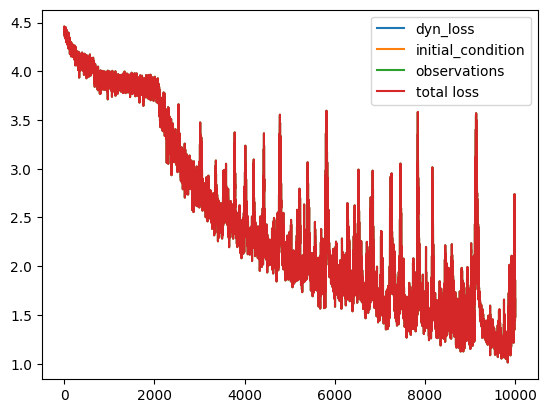

In [ ]:
for loss_name, loss_values in loss_by_term_dict.items():
#     if loss_name == "dyn_loss":
        plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

In [ ]:
# And then we fix the weights for the DynamicLoss part
alpha = 1
loss_weights = {
    "dyn_loss":{"Ip":alpha, "Ii":alpha, "G":alpha*1e-2, "h1":alpha, "h2":alpha, "h3":alpha}, "initial_condition":1, "observations": 1e-2
}

loss = jinns.loss.SystemLossODE(
    u_dict={"Ii":nn_list[0], "Ip":nn_list[1], "G":nn_list[2], "h1":nn_list[3], "h2":nn_list[4], "h3":nn_list[5]},
    loss_weights=loss_weights,
    dynamic_loss_dict={"Ip":sbinn_Ip, "Ii":sbinn_Ii, "G":sbinn_G, "h1":sbinn_h1, "h2":sbinn_h2, "h3":sbinn_h3},
    initial_condition_dict=None,
)

In [ ]:
n_iter = int(40000)

In [ ]:
key, subkey = random.split(key)
params, total_loss_list, loss_by_term_dict, train_data, loss, opt_state, _ , _, _ = jinns.solve(
    n_iter=n_iter,
    init_params=params,
    data=train_data,
    loss=loss,
    obs_data=obs_data,
    optimizer=tx,
)

Iteration 0: loss value = 9357.716796875


  0%|          | 0/40000 [00:00<?, ?it/s]

Iteration 1000: loss value = 329.1771240234375
Iteration 2000: loss value = 202.60145568847656
Iteration 3000: loss value = 277.12213134765625
Iteration 4000: loss value = 279.98480224609375
Iteration 5000: loss value = 217.9249267578125
Iteration 6000: loss value = 283.007568359375
Iteration 7000: loss value = 147.1026153564453
Iteration 8000: loss value = 165.93527221679688
Iteration 9000: loss value = 210.18832397460938
Iteration 10000: loss value = 172.60125732421875
Iteration 11000: loss value = 240.9892120361328
Iteration 12000: loss value = 197.43020629882812
Iteration 13000: loss value = 218.0092315673828
Iteration 14000: loss value = 161.2215118408203
Iteration 15000: loss value = 145.014892578125
Iteration 16000: loss value = 183.4419403076172
Iteration 17000: loss value = 221.83761596679688
Iteration 18000: loss value = 211.79916381835938
Iteration 19000: loss value = 285.73260498046875
Iteration 20000: loss value = 213.307861328125
Iteration 21000: loss value = 148.52496337

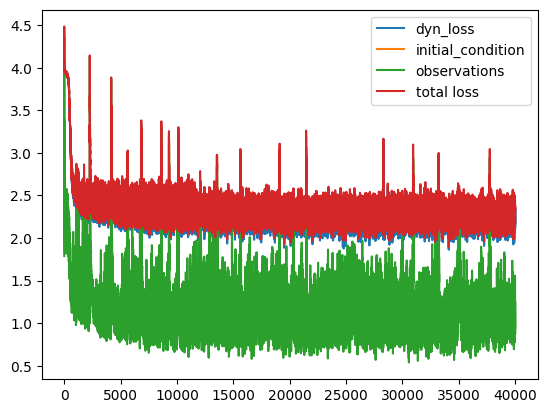

In [ ]:
for loss_name, loss_values in loss_by_term_dict.items():
#     if loss_name == "dyn_loss":
        plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

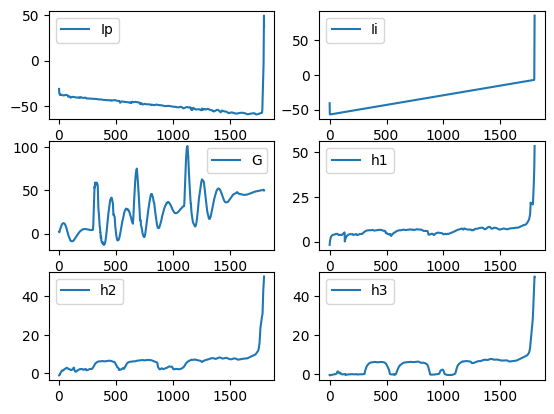

In [ ]:
u_est_Ip = vmap(lambda t:u(t, params["nn_params"])[0], (0), 0)
u_est_Ii = vmap(lambda t:u(t, params["nn_params"])[1], (0), 0)
u_est_G = vmap(lambda t:u(t, params["nn_params"])[2], (0), 0)
u_est_h1 = vmap(lambda t:u(t, params["nn_params"])[3], (0), 0)
u_est_h2 = vmap(lambda t:u(t, params["nn_params"])[4], (0), 0)
u_est_h3 = vmap(lambda t:u(t, params["nn_params"])[5], (0), 0)

key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)

fig, axes = plt.subplots(3, 2)
labels = ["Ip", "Ii", "G", "h1", "h2", "h3"]
for i in range(3):
    for j in range(2):
        idx = jnp.ravel_multi_index((i, j), (3, 2))
        u_est_ij = vmap(lambda t:u(t, {"nn_params":params["nn_params"][labels[idx]], "eq_params":params["eq_params"]}), 0, 0)
        axes[i, j].plot(val_data.times.sort(axis=0) * Tmax, u_est_ij(val_data.times.sort(axis=0)), label=labels[idx])
        axes[i, j].legend()

## Compare with the scipy solver

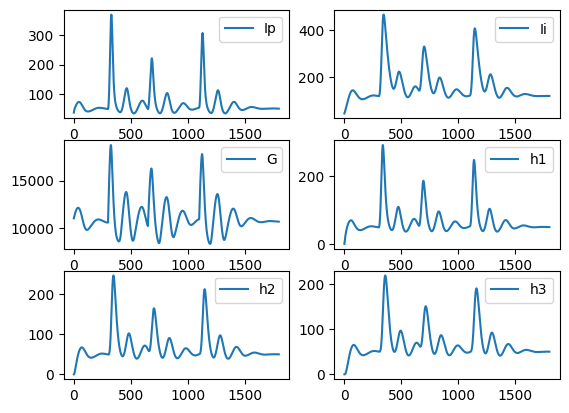

In [ ]:
import numpy as np
from scipy.integrate import odeint


def glucose_insulin_model(
    t,
    meal_t,
    meal_q,
    Vp=3,
    Vi=11,
    Vg=10,
    E=0.2,
    tp=6,
    ti=100,
    td=12,
    k=1 / 120,
    Rm=209,
    a1=6.6,
    C1=300,
    C2=144,
    C3=100,
    C4=80,
    C5=26,
    Ub=72,
    U0=4,
    Um=90,
    Rg=180,
    alpha=7.5,
    beta=1.772,
):
    def func(y, t):
        f1 = Rm / (1 + np.exp(-y[2] / Vg / C1 + a1))
        f2 = Ub * (1 - np.exp(-y[2] / Vg / C2))
        kappa = (1 / Vi + 1 / E / ti) / C4
        f3 = (U0 + Um / (1 + (kappa * y[1]) ** (-beta))) / Vg / C3
        f4 = Rg / (1 + np.exp(alpha * (y[5] / Vp / C5 - 1)))
        IG = np.sum(
            meal_q * k * np.exp(Tmax * k * (meal_t - t)) * np.heaviside(Tmax * (t - meal_t), 0.5)
        )
        tmp = E * (y[0] / Vp - y[1] / Vi)
        return [
            Tmax * (f1 - tmp - y[0] / tp),
            Tmax * (tmp - y[1] / ti),
           Tmax * ( f4 + IG - f2 - f3 * y[2]),
            Tmax * ((y[0] - y[3]) / td),
            Tmax * ((y[3] - y[4]) / td),
            Tmax * ((y[4] - y[5]) / td),
        ]

    Vp0, Vi0, Vg0 = 3, 11, 10
    y0 = [12 * Vp0, 4 * Vi0, 110 * Vg0 ** 2, 0, 0, 0]
    return odeint(func, y0, t)


meal_t = np.array([300, 650, 1100, 2000]) / Tmax
meal_q = np.array([60e3, 40e3, 50e3, 100e3])
t = np.arange(0, 1800, 1)[:, None] / Tmax
y = glucose_insulin_model(np.ravel(t), meal_t, meal_q)

fig, axes = plt.subplots(3, 2)
labels = ["Ip", "Ii", "G", "h1", "h2", "h3"]
for i in range(3):
    for j in range(2):
        idx = jnp.ravel_multi_index((i, j), (3, 2))
        axes[i, j].plot(t * Tmax, y[:, idx], label=labels[idx])
        axes[i, j].legend()